import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

Preprocess Function

In [ ]:
# Load and preprocess data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

def rf_preprocessing(df):
    # Clean data
    df = df.drop('customerID', axis=1)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

    # Feature engineering
    df['TenureToContract'] = df['tenure'] / df['Contract'].map({
        'Month-to-month': 1,
        'One year': 12,
        'Two year': 24
    })
    # This is another feature engineering trick to combine multiple related columns into one powerful feature.
    df['ServiceDensity'] = df[['OnlineSecurity', 'OnlineBackup',
                             'DeviceProtection', 'TechSupport']].apply(
                                 lambda x: x.str.contains('Yes').sum(), axis=1)

    # Simplify categories (avoids repeating similar code many times)
    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in service_cols: # (Reducing redundant categories can improve model accuracy and prevent overfitting.)
        df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

    # Target conversion
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df

preprocess data

In [ ]:
df = rf_preprocessing(df)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify=y, random_state=42) # (If data is imbalanced, always use stratify=y to maintain the same distribution in both sets.)

# Preprocessing setup
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges',
                   'TenureToContract', 'ServiceDensity']
categorical_features = ['gender', 'Partner', 'InternetService',
                       'Contract', 'PaymentMethod']

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(drop='if_binary'), categorical_features) # One-hot encoding prevents models from interpreting category labels as numeric values.
])

Apply preprocessing and run the model

In [ ]:
# Create optimized pipeline
pipeline = ImbPipeline([ # ImbPipeline is used because SMOTE must happen only on training data, not before train/test split.
    ('preprocessor', preprocessor), # scaling/encoding columns as defined earlier
    ('smote', SMOTE(sampling_strategy=0.5)), # (Synthetic Minority Over-sampling Technique) to handle class imbalance.
    ('classifier', RandomForestClassifier(class_weight='balanced')) # Automatically adjusts weights inversely proportional to class frequencies.
])

# Hyperparameter grid
param_grid = { # Defines the hyperparameters and their possible values for tuning the Random Forest:
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
} # We want to find the best combination of parameters to maximize model performance.

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                          scoring='roc_auc', n_jobs=-1, verbose=1) # Uses AUC-ROC score to judge performance. (good for imbalanced classification because it considers both true positives and false positives.)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Test Accuracy: 0.7665
AUC-ROC: 0.8391

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.55      0.71      0.62       374

    accuracy                           0.77      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.77      0.77      1409



Model evalution

<ipython-input-6-3932b1dfb902>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(all_feature_names)[sorted_idx][:10], y=importances[sorted_idx][:10], palette="viridis")


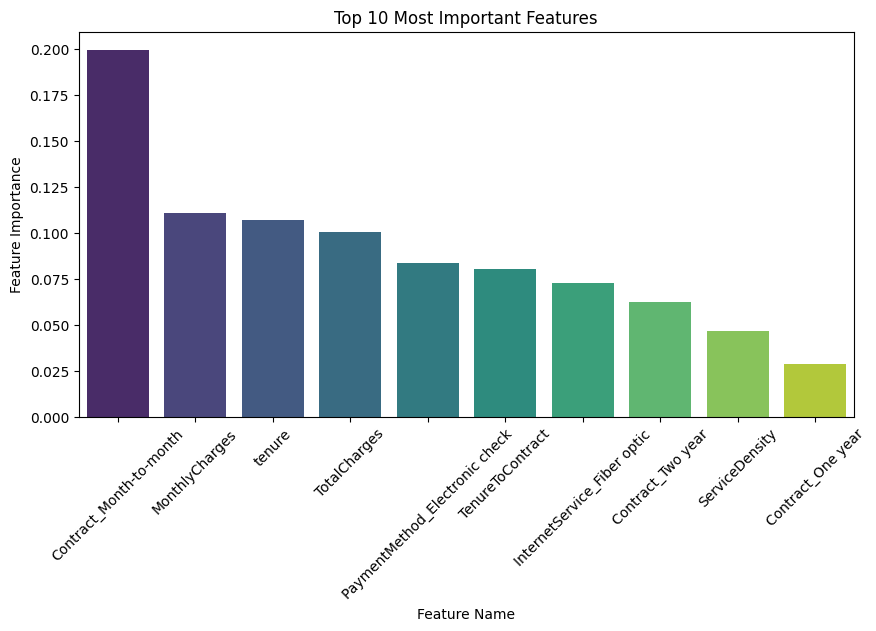

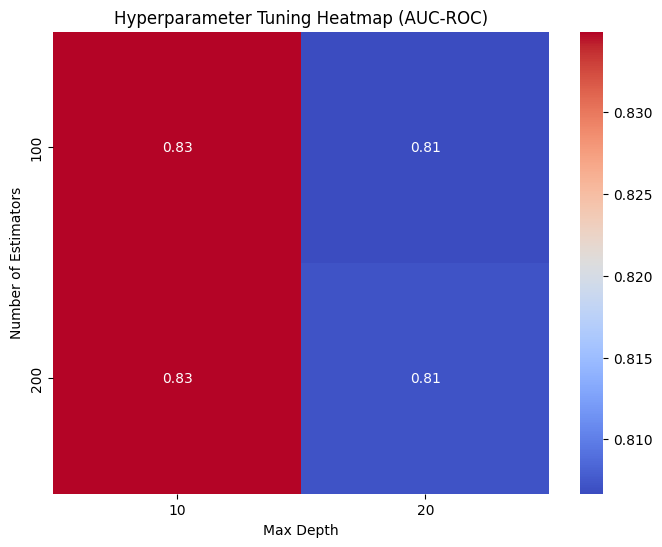

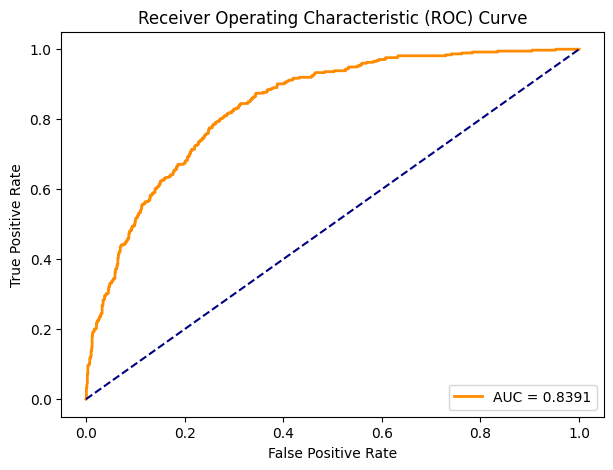

In [ ]:
# ==============================
# 1. Feature Importance Plot
# ==============================
fitted_preprocessor = best_model.named_steps['preprocessor']
cat_transformer = fitted_preprocessor.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = best_model.named_steps['classifier'].feature_importances_

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
sns.barplot(x=np.array(all_feature_names)[sorted_idx][:10], y=importances[sorted_idx][:10], palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Most Important Features")
plt.ylabel("Feature Importance")
plt.xlabel("Feature Name")
plt.show()

# ==============================
# 2. Hyperparameter Tuning Heatmap
# ==============================
cv_results = pd.DataFrame(grid_search.cv_results_)
pivot_table = cv_results.pivot_table(index='param_classifier__n_estimators',
                                     columns='param_classifier__max_depth',
                                     values='mean_test_score')

plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title("Hyperparameter Tuning Heatmap (AUC-ROC)")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

# ==============================
# 3. ROC Curve
# ==============================
fpr, tpr, _ = roc_curve(y_test, y_proba) # Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds.
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


save model

In [9]:
# 🔹 Save Model
joblib.dump(best_model, "random_forest_model.pkl")
print("Model saved successfully!")

Model saved successfully!


# Test Model with real data

In [10]:


# Create synthetic data
test_data = pd.DataFrame({
    'tenure': [5, 24, 60],
    'MonthlyCharges': [29.85, 56.95, 99.65],
    'TotalCharges': [150.5, 1500.6, 5986.5],
    'TenureToContract': [5/1, 24/12, 60/24],
    'ServiceDensity': [2, 3, 4],
    'gender': ['Female', 'Male', 'Female'],
    'Partner': ['Yes', 'No', 'Yes'],
    'InternetService': ['DSL', 'Fiber optic', 'No'],
    'Contract': ['Month-to-month', 'One year', 'Two year'],
    'PaymentMethod': ['Electronic check', 'Mailed check', 'Credit card (automatic)']
})

# Save for use if needed
test_data.to_csv('synthetic_test_data.csv', index=False)
print("Synthetic test dataset created!")


Synthetic test dataset created!


In [11]:
# Load saved model
model = joblib.load("random_forest_model.pkl")

# Predict churn probabilities
predictions = model.predict(test_data)
proba = model.predict_proba(test_data)[:, 1]

# Display results
for i, (p, prob) in enumerate(zip(predictions, proba)):
    print(f"Customer {i+1}: Churn = {p} | Probability = {prob:.4f}")

Customer 1: Churn = 0 | Probability = 0.4984
Customer 2: Churn = 0 | Probability = 0.1295
Customer 3: Churn = 0 | Probability = 0.0203
